## Introduction 
#### what is a neural network?
 A neural Network is a computational model inspired by the human brain. Each neuron recieves an activation signal from the preceeding layer and computes some value that is propoagated forward
 #### Key Concepts:
 - **Input Layer**: Receives the raw input data (e.g., pixel values from an image).
 - **Hidden Layers**: Perform computations to extract meaningful features.
 - **Output Layer**: Produces the final predictions (e.g., the digit class).

 #### Activation Functions:
 Activation functions (e.g., ReLU, sigmoid) introduce non-linearity into the model, enabling it to learn complex patterns.

 #### Loss Function:
 The loss function measures the error between the predicted outputs and the true labels. In this task, we'll use Cross Entropy Loss, which is commonly used for classification problems.

 #### Optimization:
 The optimizer (e.g., Stochastic Gradient Descent) updates the network's weights to minimize the loss function during training.

 #### Problem Statement:
 In this assignment, we will use the MNIST dataset to train a neural network to classify handwritten digits (0-9). We'll explore various hyperparameters, analyze their effects, and optionally use advanced techniques such as convolutional layers and dropout.

## 1 Data Processing
 before we attempt to train our model we must make sure that our data conforms with required criteria:
 - the samples are tensors
 - 60 % training , 20 % validation , 20 % test 
 - keep a "straigtified" manner to avoid data skewing

In [9]:
# Import necessary libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Dataset loading (edit the path to the MNIST dataset)
from torchvision import datasets, transforms

# Apply transformations (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split training dataset into train and validation sets
train_data, val_data = train_test_split(train_dataset, test_size=0.2, stratify=train_dataset.targets)

# Create DataLoader objects for efficient batching
batch_size = 15  # You can modify this in the analysis section
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preparation complete!")


Data preparation complete!


 now we build our neural network architecture. we will start with a basic model containing a single hidden layer.

In [10]:
# 2 create neural network structure
class Neural_Network_1_hidden_layer(nn.Module):
        def __init__(self, input_size=28*28, hidden_size=10, num_classes=10):
            super(Neural_Network_1_hidden_layer, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.fc2 = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            x = x.view(-1, 28*28)  # Flatten the input
            x = torch.relu(self.fc1(x))  # Apply ReLU activation after first hidden layer
            x = self.fc2(x)  # Output layer
            return x

 before we start the training process we need to make sure that we are using GPU accelerated training 

In [11]:

# 3. Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the selected device
model = Neural_Network_1_hidden_layer().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


 we will now proceed to train our model for 10 epochs where each epoch consists of a training phase followed by a vildation phase.

In [12]:

# 4. Training Process
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 # this is the cumulative loss during epoch
        correct_train = 0  
        total_train = 0
        
        # Train the model on the training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)


Epoch [1/10], Train Loss: 0.5966, Train Accuracy: 82.25%, Validation Loss: 0.3849, Validation Accuracy: 88.78%
Epoch [2/10], Train Loss: 0.3562, Train Accuracy: 89.48%, Validation Loss: 0.3484, Validation Accuracy: 89.79%
Epoch [3/10], Train Loss: 0.3332, Train Accuracy: 90.40%, Validation Loss: 0.3452, Validation Accuracy: 89.78%
Epoch [4/10], Train Loss: 0.3166, Train Accuracy: 90.72%, Validation Loss: 0.3723, Validation Accuracy: 89.48%
Epoch [5/10], Train Loss: 0.3040, Train Accuracy: 91.31%, Validation Loss: 0.3217, Validation Accuracy: 90.93%
Epoch [6/10], Train Loss: 0.2953, Train Accuracy: 91.46%, Validation Loss: 0.3141, Validation Accuracy: 91.26%
Epoch [7/10], Train Loss: 0.2870, Train Accuracy: 91.65%, Validation Loss: 0.3055, Validation Accuracy: 91.38%
Epoch [8/10], Train Loss: 0.2811, Train Accuracy: 91.90%, Validation Loss: 0.2931, Validation Accuracy: 91.83%
Epoch [9/10], Train Loss: 0.2748, Train Accuracy: 92.01%, Validation Loss: 0.3025, Validation Accuracy: 91.47%
E

 now we plot the performance of our simple model

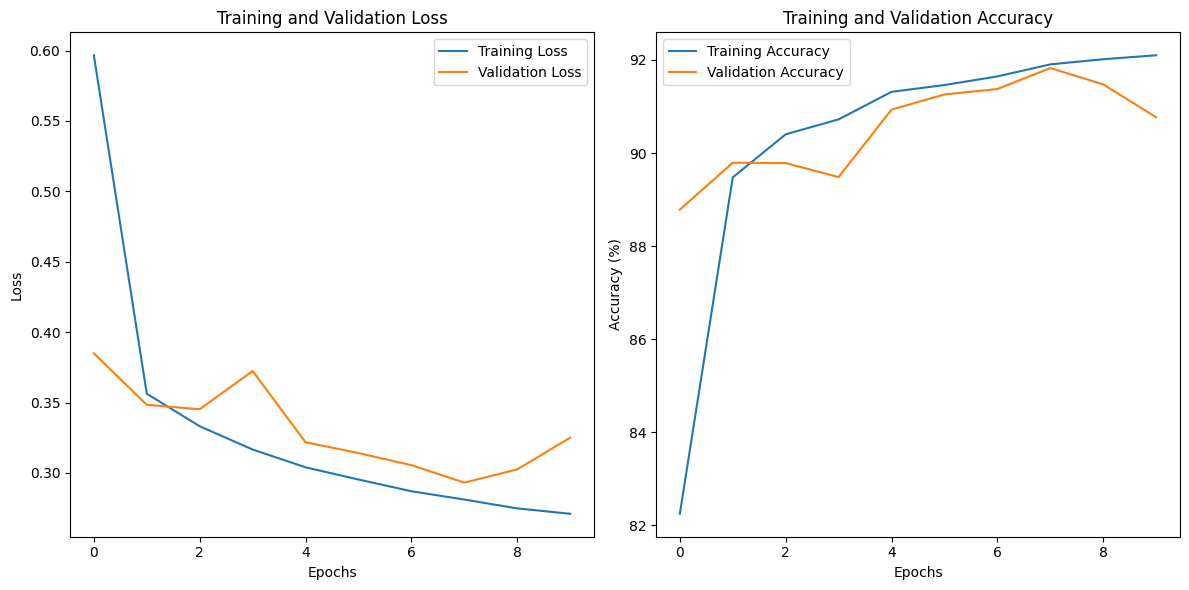

In [14]:
# 5. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 6. Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## part 2
 for this part we will attempt to tune the model parameters by tweaking a single paramter and retraining the model and then comparing results we will use the following paramters:
 
 - number of hiddden